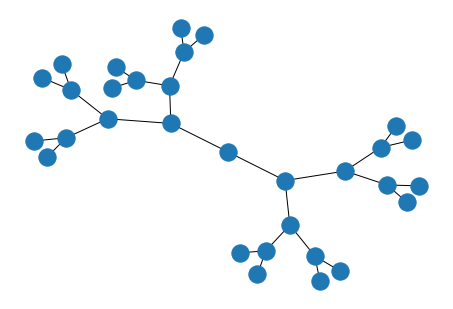

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

def RGgraph_skeleton():
    """ Creates boundary graph (collection of nodes) corresponding to the spin lattice, and the 'bare' tree graph
        
        Returns:
            bdG: dtype networkx multigraph
                boundary graph
            
            bulkG: dtype networkx multigraph
                'bare' tree graph, i.e. the boundary + bulk tree graph that serves as a skeleton for the RGb graph
    """
    # Boundary graph
    bdG = nx.MultiGraph()
    for i in range(N):
        bdG.add_node(i)
    # Bulk graph
    n_nodes_shell = N; add = 0
    bulkG = bdG.copy()
    while n_nodes_shell > 1:
        for k in np.arange(0,n_nodes_shell,2):
            n_Gr = nx.number_of_nodes(bulkG); bulkG.add_node(n_Gr)
            bulkG.add_edge(n_Gr,k+add); bulkG.add_edge(n_Gr,k+1+add)
        add += n_nodes_shell
        n_nodes_shell //= 2
    return(bdG, bulkG)

def RGlats_skeleton():
    """ Creates the 'bare' shells of the RGb graph. That is, a list of spin lattices of decreasing size in accordance with the 
        branching factor 2, that serve as 'skeleton lattices' that can be modified by the RGb procedure
        
        Returns: 
            lats: dtype list
                list of lattice arrays. They serve as the initial spin lattices that constitute the shells of the RGb graph
    """
    lats = []; lats.append(np.zeros(N))
    n_nodes_shell = N
    while n_nodes_shell > 1:
        n_nodes_shell //= 2
        new_lat = np.zeros(n_nodes_shell)
        lats.append(new_lat)
    return(lats)

def create_frozen_map(lat):
    """ Creates a boolean map of (freezes) all bonds (nn interactions) in the lattice
    
        Input:
            lat: dtype numpy array
                [N] array containing only 1 and -1 values representing the spin configuration
            
        Returns:
            f_map: dtype numpy array
                [N] boolean array containing True if bond is present or False if not. For example spin lattice [1, -1, 1, 1]
                corresponds to f_map [True, True, False, False]
    """
    lat = np.array(lat)
    a = lat[1:]-lat[0:len(lat)-1]; b = lat[0]-lat[len(lat)-1]
    c = np.append(a,b)
    f_map = (c == 0)
    return(f_map)

def construct_graph(lat, lats, Gr):
    """ Construct graph from spin lattice according to the RGb procedure
        
        Input: 
            lat: dtype numpy array
                [N] array containing only 1 and -1 values representing the spin configuration
            
            lats: dtype list
                list containing the initial spin lattices that constitutes the shells of the graph (i.e. as constructed by the 
                function 'RGlats_skeleton')
            
            Gr: dtype networkx multigraph
                'bare' tree graph that serves as the 'skeleton' for the RGb graph (i.e. as constructed by the function 
                'RGgraph_skeleton')
            
        Returns: 
            Gr: dtype networkx multigraph
                RGb graph
    """
    n_nodes_shell = N; shell = 0
    add = 0 
    Gr = Gr.copy()
    while shell < len(lats):
        lats[shell] = lat
        if shell == (len(lats)-1):
            break
            
        # Update RG graph accordingly:
        frm = create_frozen_map(lat)
        idx = np.where(frm==False)
        for i in idx[0]:
            Gr.add_edge(i+add, (i+1)%n_nodes_shell+add)    
        add += n_nodes_shell
        
        # Do RG step:
        old_lat = lat
        n_nodes_shell //= 2
        lat = lat.reshape(n_nodes_shell, 2)
        lat = np.sum(lat, axis=1)
        # Deal with ties:
        idx_zeros = np.where(lat==0)
        old_idx_zeros = tuple([2*i for i in idx_zeros])
        lat[idx_zeros] = old_lat[old_idx_zeros] #np.random.choice([1,-1], size=len(idx_zeros[0]))
        lat = lat/abs(lat)
        
        shell += 1
    return(Gr)

N = 16 # Global parameter denoting the number of spins (boundary nodes)
lattice = np.ones(N)
bdG, initG = RGgraph_skeleton()
lattices = RGlats_skeleton()
G = construct_graph(lattice, lattices, initG)
nx.draw(G)